In [48]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from nbconvert import PythonExporter
import os
from tqdm import tqdm
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, log_loss
import time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping


In [49]:
# adding the images, labels, styles 
file_path = "../raw_data/data_sampling1000_topstyles10.csv"
df = pd.read_csv(file_path)
df.head()

,artist,style,movement,tags,url,img,file_name,genre_list,Artwork,Date
0,Panayiotis Tetsis,Impressionism,Post-Impressionism,NaN,https://www.wikiart.org/en/panayiotis-tetsis/s...,https://uploads3.wikiart.org/images/panayiotis...,127519-sunset.jpg,['cloudscape'],NaN,NaN
1,Henry Scott Tuke,Impressionism,Impressionism,"['Fun', 'Vacation', 'summer']",https://www.wikiart.org/en/henry-scott-tuke/th...,https://uploads5.wikiart.org/00261/images/henr...,100529-henry-scott-tuke-the-bathers-1922.jpg,['genre painting'],NaN,NaN
2,Alfred Sisley,Impressionism,Impressionism,"['fires-and-floods', 'forests-and-trees', 'Ban...",https://www.wikiart.org/en/alfred-sisley/the-f...,https://uploads1.wikiart.org/images/alfred-sis...,92312-the-flood-on-the-road-to-saint-germain-1...,['landscape'],NaN,NaN
3,Camille Pissarro,Impressionism,Impressionism,"['Grassland', 'Meadow', 'Pasture', 'Plain']",https://www.wikiart.org/en/camille-pissarro/ro...,https://uploads2.wikiart.org/images/camille-pi...,90106-rolling-landscape-in-winter-1875.jpg,['landscape'],NaN,NaN
4,Guy Rose,Impressionism,Impressionism,"['seas-and-oceans', 'cliffs-and-rocks', 'Bank'...",https://www.wikiart.org/en/guy-rose/grey-after...,https://uploads3.wikiart.org/images/guy-rose/g...,104411-grey-afternoon.jpg,['landscape'],NaN,NaN


In [50]:
def load_and_resize_images(image_dir):
    """
    Charge toutes les images d'un dossier, les redimensionne en conservant le ratio
    avec padding noir et les retourne sous forme de tableau NumPy.
    
    Args:
        image_dir (str): Chemin vers le dossier contenant les images.
        target_size (tuple): Taille finale des images (largeur, hauteur).
        
    Returns:
        np.ndarray: Tableau de forme (n_images, hauteur, largeur, canaux)
    """
    images_list = []
    
    for filename in os.listdir(image_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(image_dir, filename)
            img = Image.open(img_path).convert('RGB') 

            img_resized = img.resize((128, 128), Image.BICUBIC)
            
            # convert into an array and add to list 
            img_array = np.array(img_resized)
            images_list.append(img_array)
    
    # Convertir la liste en tableau NumPy
    images_np = np.stack(images_list)
    return images_np

In [51]:
image_dir = "../raw_data/1000_samples/1000_samples"
images_np = load_and_resize_images(image_dir)

In [52]:
X = np.array(images_np, dtype='float32') / 255.0

In [53]:
y = df['style']

In [54]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1000, 128, 128, 3)
y shape: (1000,)


In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,      
    random_state=42,
    stratify=y
)

In [57]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [58]:
### Encoding the labels
y_train_cat = to_categorical(y_train_encoded, 10).astype('float32')
y_test_cat = to_categorical(y_test_encoded, 10).astype('float32')

In [59]:
def set_nontrainable_layers(model):

    # Set the first layers to be untrainable
    model.trainable = False

    return model

In [60]:
def load_model():
    model = ResNet50(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    return model


In [61]:
model = load_model()
model = set_nontrainable_layers(model)
model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [62]:

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer1 = layers.Dense(500, activation='relu')
    dense_layer2 = layers.Dense(250, activation='relu')

    prediction_layer = layers.Dense(10, activation='softmax')
    
    
    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer1,
        dense_layer2,
        prediction_layer
    ])
    return model

In [63]:
model = add_last_layers(model)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 500)            │    16,384,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 250)            │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         2,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,099,972 (152.97 MB)

 Trainable params: 16,512,260 (62.99 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [64]:
def build_model():
    # $CHALLENGIFY_BEGIN    
    model = load_model()
    model = add_last_layers(model)
    
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [65]:
model = build_model()

In [66]:
es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

history = model.fit(X_train, y_train_cat, 
                    validation_split=0.1, 
                    epochs=50, 
                    batch_size=16, 
                    callbacks=[es])

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 541ms/step - accuracy: 0.1084 - loss: 2.4155 - val_accuracy: 0.1143 - val_loss: 2.3569
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 479ms/step - accuracy: 0.1022 - loss: 2.3361 - val_accuracy: 0.0857 - val_loss: 2.3588
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 453ms/step - accuracy: 0.1433 - loss: 2.2820 - val_accuracy: 0.0857 - val_loss: 2.3653
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 462ms/step - accuracy: 0.1424 - loss: 2.2682 - val_accuracy: 0.0857 - val_loss: 2.3500
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 449ms/step - accuracy: 0.1416 - loss: 2.2738 - val_accuracy: 0.0714 - val_loss: 2.4279
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 419ms/step - accuracy: 0.1427 - loss: 2.3099 - val_accuracy: 0.1000 - val_loss: 2.3438
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


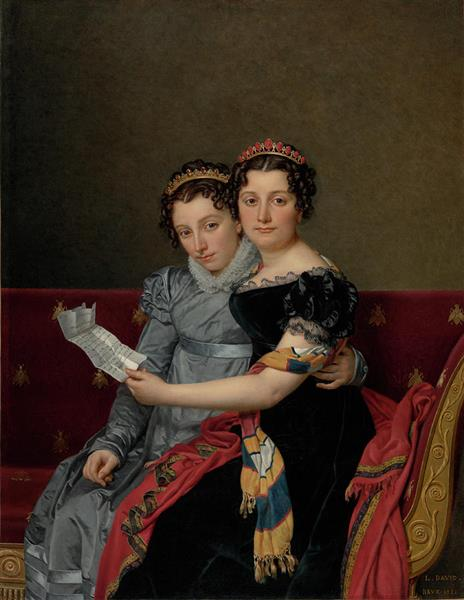

In [67]:
from PIL import Image
import os

# Chemin vers le dossier contenant l'image
image_path = "../raw_data/1000_samples/1000_samples/30953-portrait-of-the-sisters-zenaide-and-charlotte-bonaparte-jacques-louis-david.jpg"

from PIL import Image
img = Image.open(image_path)
img

In [68]:
img_array = np.array(img) 
img_array.shape

(600, 464, 3)

In [69]:
# Redimensionner à 128x128
img_resized = img.resize((128, 128), Image.BICUBIC)

# Convertir en array si besoin
import numpy as np
img_array_resized = np.array(img_resized)
print(img_array_resized.shape)

(128, 128, 3)


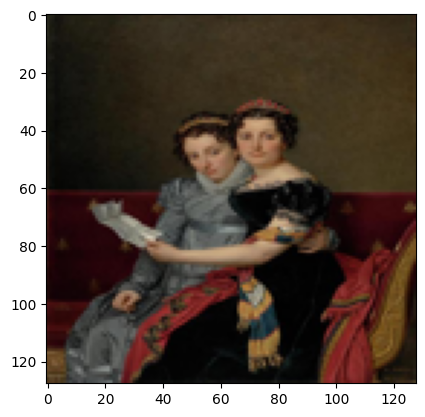

In [70]:
plt.imshow(img_resized)

In [71]:
y_pred = model.predict(img_array_resized.reshape(1, 128, 128, 3))
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[1.0332459e-02, 3.4160143e-01, 1.5187156e-01, 1.8267918e-01,
        7.1364895e-02, 9.3811855e-02, 3.0875378e-04, 4.9485336e-03,
        1.7377838e-02, 1.2570354e-01]], dtype=float32)

In [76]:
# index des classes prédites
pred_indices = y_pred.argmax(axis=1)
# convertit en labels d'origine
pred_labels = le.inverse_transform(pred_indices)
pred_labels

array(['Cubism'], dtype=object)

In [72]:
df[df["file_name"].str.contains("30953-portrait-of-the-sisters-zenaide-and-charlotte-bonaparte-jacques-louis-david")]

,artist,style,movement,tags,url,img,file_name,genre_list,Artwork,Date
870,Jacques-Louis David,Neoclassicism,Neoclassicism,['female-portraits'],https://www.wikiart.org/en/jacques-louis-david...,https://uploads7.wikiart.org/00380/images/jacq...,30953-portrait-of-the-sisters-zenaide-and-char...,['portrait'],NaN,NaN


In [74]:
# Sauvegarder le modèle en format Keras (meilleur si possible)
from tensorflow import keras
#keras.saving.save_model(model, filepath='../models/mymodel', save_format='tf')
#keras.saving.save_model(model, filepath='../models/mymodel.h5', save_format='h5')
keras.saving.save_model(model, filepath='../models/mymodel.keras', save_format='keras')

AttributeError: module 'tensorflow.keras' has no attribute 'saving'

In [77]:
image_path = "../raw_data/1000_samples/1000_samples/31159-landscape-with-an-aqueduct-lacma-58-47-2-b.jpg"

from PIL import Image
img = Image.open(image_path)

In [78]:
img_array = np.array(img) 
img_array.shape

(600, 706, 3)

In [79]:
# Redimensionner à 128x128
img_resized = img.resize((128, 128), Image.BICUBIC)

# Convertir en array si besoin
import numpy as np
img_array_resized = np.array(img_resized)
print(img_array_resized.shape)

(128, 128, 3)


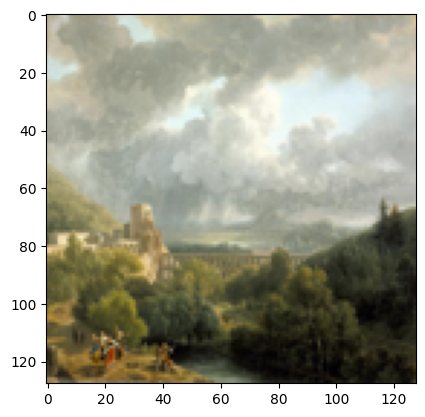

In [80]:
plt.imshow(img_resized)

In [81]:
y_pred = model.predict(img_array_resized.reshape(1, 128, 128, 3))
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


array([[0.00196482, 0.04231773, 0.27509663, 0.10349702, 0.2876069 ,
        0.10183148, 0.00218389, 0.01040774, 0.05428053, 0.12081321]],
      dtype=float32)

In [83]:
# index des classes prédites
pred_indices = y_pred.argmax(axis=1)
# convertit en labels d'origine
pred_labels = le.inverse_transform(pred_indices)
pred_labels

array(['Neoclassicism'], dtype=object)

In [84]:
df[df["file_name"].str.contains("31159-landscape-with-an-aqueduct-lacma-58-47-2-b")]

,artist,style,movement,tags,url,img,file_name,genre_list,Artwork,Date
871,Nicolas Antoine Taunay,Neoclassicism,Neoclassicism,NaN,https://www.wikiart.org/en/nicolas-antoine-tau...,https://uploads7.wikiart.org/00324/images/nico...,31159-landscape-with-an-aqueduct-lacma-58-47-2...,['landscape'],NaN,NaN


In [85]:
image_path = "../raw_data/Paul_Cézanne_-_The_Basket_of_Apples_-_1926.252_-_Art_Institute_of_Chicago.jpg"

from PIL import Image
img = Image.open(image_path)

In [86]:
img_array = np.array(img) 
img_array.shape

(2250, 2811, 3)

In [87]:
# Redimensionner à 128x128
img_resized = img.resize((128, 128), Image.BICUBIC)

# Convertir en array si besoin
import numpy as np
img_array_resized = np.array(img_resized)
print(img_array_resized.shape)

(128, 128, 3)


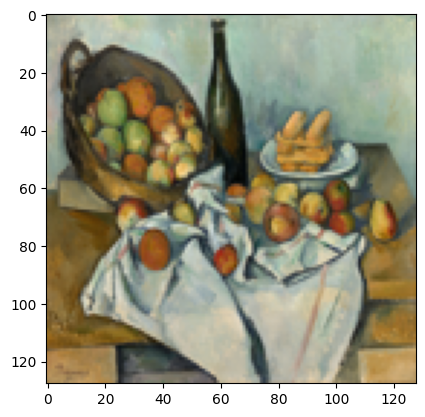

In [88]:
plt.imshow(img_resized)

In [89]:
y_pred = model.predict(img_array_resized.reshape(1, 128, 128, 3))
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


array([[4.2129558e-04, 2.2420521e-01, 2.3284666e-02, 1.8411851e-01,
        5.0797433e-01, 2.3107728e-02, 2.8970678e-04, 6.4029748e-04,
        7.2899152e-04, 3.5229355e-02]], dtype=float32)

In [90]:
# index des classes prédites
pred_indices = y_pred.argmax(axis=1)
# convertit en labels d'origine
pred_labels = le.inverse_transform(pred_indices)
pred_labels

array(['Neoclassicism'], dtype=object)

In [97]:
image_path = "../raw_data/Piet_Mondriaan,_1942_-_New_York_City_I.jpg"

from PIL import Image
img = Image.open(image_path)

In [92]:
img_array = np.array(img) 
img_array.shape

(1012, 960, 3)

In [93]:
# Redimensionner à 128x128
img_resized = img.resize((128, 128), Image.BICUBIC)

# Convertir en array si besoin
import numpy as np
img_array_resized = np.array(img_resized)
print(img_array_resized.shape)

(128, 128, 3)


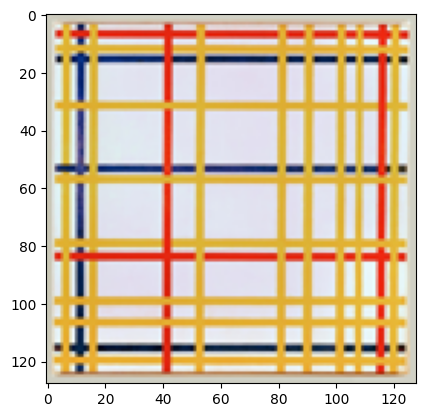

In [94]:
plt.imshow(img_resized)

In [95]:
y_pred = model.predict(img_array_resized.reshape(1, 128, 128, 3))
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


array([[0.00726017, 0.01123991, 0.38994196, 0.2905629 , 0.03747277,
        0.16013885, 0.01006149, 0.02681046, 0.02254824, 0.0439633 ]],
      dtype=float32)

In [96]:
# index des classes prédites
pred_indices = y_pred.argmax(axis=1)
# convertit en labels d'origine
pred_labels = le.inverse_transform(pred_indices)
pred_labels

array(['Expressionism'], dtype=object)

In [98]:
image_path = "../raw_data/Two_Young_Girls_at_the_Piano_MET_rl1975.1.201.R.jpg"
img = Image.open(image_path)

In [99]:
img_array = np.array(img) 
img_array.shape

(324, 250, 3)

In [100]:
# Redimensionner à 128x128
img_resized = img.resize((128, 128), Image.BICUBIC)

# Convertir en array si besoin
import numpy as np
img_array_resized = np.array(img_resized)
print(img_array_resized.shape)

(128, 128, 3)


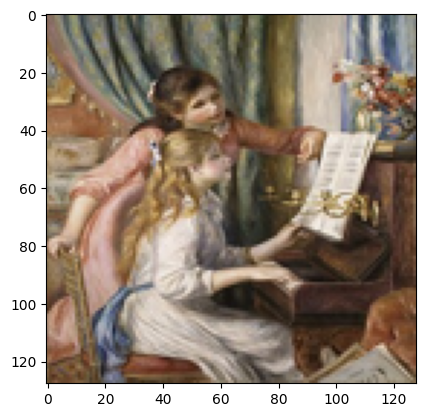

In [101]:
plt.imshow(img_resized)

In [102]:
y_pred = model.predict(img_array_resized.reshape(1, 128, 128, 3))
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


array([[3.00720730e-03, 3.34256999e-02, 6.91276193e-01, 1.27789095e-01,
        5.22167534e-02, 7.23163188e-02, 4.69737006e-06, 1.96945877e-03,
        2.51810648e-03, 1.54765695e-02]], dtype=float32)

In [104]:
# index des classes prédites
pred_indices = y_pred.argmax(axis=1)
# convertit en labels d'origine
pred_labels = le.inverse_transform(pred_indices)
pred_labels

array(['Expressionism'], dtype=object)

In [ ]:
Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg